In [32]:
# import the necessary modules
import pandas as pd
import numpy as np
import os
#waveform-database:A library of tools for reading, writing, and processing WFDB signals and annotations.
import wfdb 

%matplotlib inline
import matplotlib as mlp
import matplotlib.pyplot as plt

mlp.rc("xtick",labelsize=12)
mlp.rc("ytick",labelsize=12)
mlp.rc("axes",labelsize=14)

MAIN_PATH = "C:/Users/ACER/Desktop/ECG_2"
DATA_PATH = "C:/Users/ACER/Desktop/ECG_2/mit-bih-arrhythmia-database-1.0.0"
FIG_PATH="C:/Users/ACER/Desktop/ECG_2"
FIGURE_PATH = os.path.join(FIG_PATH,"saved_figures")
os.makedirs("saved_figures",exist_ok=True)
os.chdir(DATA_PATH)

#a function to save plotted figures
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(FIGURE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [33]:
records = np.loadtxt(os.path.join(DATA_PATH,"RECORDS"), dtype=str)
print(records)
print(len(records))

['100' '101' '102' '103' '104' '105' '106' '107' '108' '109' '111' '112'
 '113' '114' '115' '116' '117' '118' '119' '121' '122' '123' '124' '200'
 '201' '202' '203' '205' '207' '208' '209' '210' '212' '213' '214' '215'
 '217' '219' '220' '221' '222' '223' '228' '230' '231' '232' '233' '234']
48


In [34]:
def read_data():
    dataset = []
    for record in records:
        temp = wfdb.rdrecord(record)
        dataset.append(temp.p_signal)
    return dataset
dataset = read_data()

In [35]:
invalid_beat = [
    "[", "!", "]", "x", "(", ")", "p", "t", 
    "u", "`", "'", "^", "|", "~", "+", "s", 
    "T", "*", "D", "=",'"', "@", "B", "a", "J", "S",
    "r", "F", "e", "j", "n", "f", "Q", "?"
]

label_beats=[
    "A", "L", "/", "V", "R", "E", "N"
]

# Loading signals and segmentation

In [36]:
import wfdb
import pywt
import numpy as np
from scipy.ndimage import median_filter
from scipy.signal import savgol_filter

def classify(symbol):
    if symbol in label_beats:
        return 1
    else:
        return 0

def segment(signal_MLII, beat_loc):
    window = 180
    x = beat_loc - window
    y = beat_loc + window
    samp = signal_MLII[x:y]
    return samp

def perform_swt(signal, wavelet='db1', level=3):
    # Perform SWT decomposition
    coeffs = pywt.swt(signal, wavelet=wavelet, level=level)
    return coeffs

def two_stage_median_filter(signal, size=3):
    # First stage: apply median filter
    first_stage = median_filter(signal, size=size)
    
    # Second stage: apply median filter again
    second_stage = median_filter(first_stage, size=size)
    
    return second_stage

def apply_savitzky_golay(signal, window_length=5, polyorder=2):
    # Apply Savitzky-Golay filter
    return savgol_filter(signal, window_length=window_length, polyorder=polyorder)

def perform_iswt(coeffs):
    # Perform Inverse SWT
    reconstructed_signal = pywt.iswt(coeffs)
    return reconstructed_signal

# Initialize lists to store signals and labels
all_signals = []
all_labels = []

# Replace 'records' with your actual records list


# Perform filtering and SWT on all signals


# Example output of reconstructed signals



In [37]:
for record in records:
    temp = wfdb.rdrecord(record)
    annot_temp = wfdb.rdann(record, 'atr')
    ann_sample = annot_temp.sample
    ann_symbol = annot_temp.symbol
    signal = temp.p_signal
    signal_MLII = signal[:, 0]
    
    for i, i_sample in enumerate(ann_sample):
        label_dec = classify(ann_symbol[i])
        segmentation = segment(signal_MLII, i_sample)
        if label_dec == 1 and len(segmentation) == 360:
            all_signals.append(segmentation)
            all_labels.append(ann_symbol[i])

In [39]:
all_swt_coeffs = []
all_reconstructed_signals = []

# signal process

In [40]:
def perform_iswt(coeffs, wavelet='db1'):
    # Perform Inverse SWT
    reconstructed_signal = pywt.iswt(coeffs, wavelet)
    return reconstructed_signal

# Main processing loop
for signal in all_signals:
    # Perform SWT on the original signal
    swt_coeffs = perform_swt(signal, wavelet='db1')  # Specify the wavelet here
    all_swt_coeffs.append(swt_coeffs)
    
    # Filter the SWT coefficients (you may need to adjust this part)
    filtered_coeffs = []
    for coeff in swt_coeffs:
        # Apply two-stage median filter and Savitzky-Golay filter to each coefficient
        filtered_detail = two_stage_median_filter(coeff[1])  # Detail coefficients
        smoothed_detail = apply_savitzky_golay(filtered_detail)
        filtered_coeffs.append((coeff[0], smoothed_detail))  # Append approximation and filtered detail

    # Perform ISWT to reconstruct the signal from the filtered coefficients
    reconstructed_signal = perform_iswt(filtered_coeffs, wavelet='db1')
    all_reconstructed_signals.append(reconstructed_signal)


# visualize the preprocess and original signal

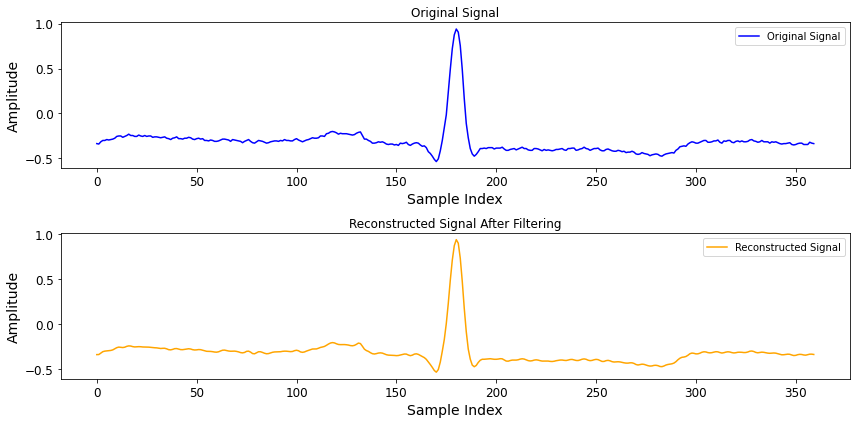

In [64]:
import matplotlib.pyplot as plt

# Assuming all_signals and all_reconstructed_signals are populated as per your processing loop

# Plot the first original signal and the first reconstructed signal
plt.figure(figsize=(12, 6))

# Plot original signal
plt.subplot(2, 1, 1)
plt.plot(all_signals[0], label='Original Signal', color='blue')
plt.title('Original Signal')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()

# Plot reconstructed signal
plt.subplot(2, 1, 2)
plt.plot(all_reconstructed_signals[0], label='Reconstructed Signal', color='orange')
plt.title('Reconstructed Signal After Filtering')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [41]:
all_signals_fin=np.vstack(all_reconstructed_signals)


In [42]:
print(all_signals_fin.shape)


(107141, 360)


In [43]:
labels_fin=pd.Series(all_labels)

labels_fin.value_counts()


N    75011
L     8071
R     7255
V     7129
/     7023
A     2546
E      106
Name: count, dtype: int64

In [44]:
len(all_signals_fin)
labels_array=np.array(all_labels)

In [45]:
df_0=all_signals_fin[labels_fin=='/']
df_1=all_signals_fin[labels_fin=='A']
df_2=all_signals_fin[labels_fin=='E']
df_3=all_signals_fin[labels_fin=='L']
df_4=all_signals_fin[labels_fin=='N']
df_5=all_signals_fin[labels_fin=='R']
df_6=all_signals_fin[labels_fin=='V']
y_df0=labels_array[labels_fin=='/']
print(len(df_0))
print(len(df_1))
print(len(df_2))

print(y_df0)
len(y_df0)

7023
2546
106
['/' '/' '/' ... '/' '/' '/']


7023

In [46]:
from sklearn.utils import resample


In [47]:
df0_sampled=resample(df_0, replace=True, n_samples=20000, random_state=42)
df1_sampled=resample(df_1, replace=True, n_samples=20000, random_state=42)
df2_sampled=resample(df_2, replace=True, n_samples=20000, random_state=42)
df3_sampled=resample(df_3, replace=True, n_samples=20000, random_state=42)
df4_sampled=resample(df_4, replace=True, n_samples=20000, random_state=42)
df5_sampled=resample(df_5, replace=True, n_samples=20000, random_state=42)
df6_sampled=resample(df_6, replace=True, n_samples=20000, random_state=42)

In [48]:
y_0=['/']*len(df0_sampled)
y_1=['A']*len(df1_sampled)
y_2=['E']*len(df2_sampled)
y_3=['L']*len(df3_sampled)
y_4=['N']*len(df4_sampled)
y_5=['R']*len(df5_sampled)
y_6=['V']*len(df6_sampled)

In [49]:
X_final=[]
X_final.extend(df0_sampled)
X_final.extend(df1_sampled)
X_final.extend(df2_sampled)
X_final.extend(df3_sampled)
X_final.extend(df4_sampled)
X_final.extend(df5_sampled)
X_final.extend(df6_sampled)

In [50]:
y_final=[]
y_final.extend(y_0)
y_final.extend(y_1)
y_final.extend(y_2)
y_final.extend(y_3)
y_final.extend(y_4)
y_final.extend(y_5)
y_final.extend(y_6)

In [51]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

In [52]:
scaled=scaler.fit_transform(X_final)


In [53]:
def check_strat(y):
    dummy = pd.DataFrame(y,columns=["Labels"])
    print("Value distribution:\n")
    count = dummy["Labels"].value_counts()
    percent = dummy["Labels"].value_counts(normalize=True).mul(100).round(2)
    print(pd.concat([count,percent],axis=1,keys=["Counts","Percent"]))

In [54]:
from sklearn.model_selection import StratifiedShuffleSplit
strad=StratifiedShuffleSplit()
assin_strad=strad.split(scaled, y_final)
train_index, test_index=next(assin_strad)
train_data_scaled=scaled[train_index]
from sklearn.preprocessing import LabelEncoder
lab=LabelEncoder()
labels_final=lab.fit_transform(y_final)
lab.classes_

array(['/', 'A', 'E', 'L', 'N', 'R', 'V'], dtype='<U1')

In [55]:
train_label=labels_final[train_index]
assin_val=strad.split(train_data_scaled, train_label)
train_index_fin, val_index=next(assin_val)
X_val=train_data_scaled[val_index]
train_data_scaled_fin=train_data_scaled[train_index_fin]
train_labels_fin=train_label[train_index_fin]
y_val=train_label[val_index]
test_data_scaled=scaled[test_index]
test_labels=labels_final[test_index]

In [56]:
check_strat(test_labels)


Value distribution:

        Counts  Percent
Labels                 
5         2000    14.29
3         2000    14.29
1         2000    14.29
6         2000    14.29
0         2000    14.29
2         2000    14.29
4         2000    14.29


In [57]:
check_strat(train_label)


Value distribution:

        Counts  Percent
Labels                 
5        18000    14.29
3        18000    14.29
0        18000    14.29
2        18000    14.29
6        18000    14.29
1        18000    14.29
4        18000    14.29


In [58]:
import os
MODEL_PATH = os.path.join(FIG_PATH,"saved_models")
os.makedirs("saved_models",exist_ok=True)

import pickle

# a function to save trained models in pickle object
def save_model(name,model,extension=".pickle"):
    path = os.path.join(MODEL_PATH,name+extension)
    print("Saving Model : ",name)
    file = open(path,"wb")
    pickle.dump(model,file)
    file.close()

In [59]:
from tensorflow import keras
CNN_X_train=train_data_scaled_fin.reshape(len(train_data_scaled_fin), len(train_data_scaled_fin[0]), 1)
CNN_val=X_val.reshape(len(X_val), len(X_val[0]), 1)

In [60]:
CNN_model = keras.Sequential()
CNN_model.add(keras.layers.Conv1D(64,kernel_size=3,input_shape=(360,1),activation="relu"))
CNN_model.add(keras.layers.MaxPool1D(pool_size=2))
CNN_model.add(keras.layers.Conv1D(filters=32,kernel_size=3,activation="relu"))
CNN_model.add(keras.layers.MaxPool1D(pool_size=2))
CNN_model.add(keras.layers.Flatten())
CNN_model.add(keras.layers.Dense(100,activation="relu"))
CNN_model.add(keras.layers.Dense(7,activation="softmax"))
loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False)
opt=keras.optimizers.Adam(lr=0.0001)
CNN_model.compile(loss=loss, optimizer=opt, metrics=['accuracy'])
CNN_model.summary()
    #X_train=X_train.reshape(len(X_train), len(X_train[0]), 1)
    #X_test=X_test.reshape(len(X_test), len(X_test[0]), 1)
history=CNN_model.fit(CNN_X_train, train_labels_fin, epochs=10, batch_size=50, validation_data=(CNN_val, y_val))
    #max_val_acc=max(history.history['accuracy'])
    
    #return CNN_model.evaluate(X_test, y_test)[1]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 358, 64)           256       
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 179, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 177, 32)           6176      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 88, 32)            0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 2816)              0         
                                                                 
 dense_2 (Dense)             (None, 100)              

In [61]:
cnn_prediction = CNN_model.predict(test_data_scaled)


438/438 [==============================] - 3s 5ms/step


In [62]:
predicted_classes = np.argmax(cnn_prediction, axis=1)

In [63]:
print(predicted_classes[0:20])
print(test_labels[0:20])

[5 3 1 1 1 6 0 2 4 3 4 1 5 0 3 0 2 4 3 3]
[5 3 1 1 1 6 0 2 4 3 4 1 5 0 3 0 2 4 3 3]
